# Imports

In [ ]:
!pip install tensorflow_text

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras import Model
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# Hyper Params

In [ ]:
classes = ['fru', 'ang', 'sad', 'hap']

model_folder = "models"

LEARNING_RATE = 1e-5
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss_func = "categorical_crossentropy"

patience = 20
callbacks = [EarlyStopping(monitor="val_accuracy", patience=patience, restore_best_weights=True)]

# Model Architecture

In [ ]:
def get_model():
    bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=True)
    bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",trainable=True)
    input_text = Input(shape=(), dtype=tf.string, name='text_input')
    text_preprocess = bert_preprocess(input_text)
    outputs_bert = bert_encoder(text_preprocess)

    #add fully connected and dropout layers
    fc1 = Dense(256, activation = 'relu', )(outputs_bert['pooled_output'])
    fc2 = Dense(128, activation='relu')(fc1)
    fc3 = Dense(4, activation='softmax')(fc2)

    model = Model(inputs = input_text, outputs = fc3)
    model.summary()
    return model


# Data Functions

In [ ]:
def get_label_vec(label):
    if label=='exc':
        label='hap'
    label_vec = np.zeros(len(classes))
    label_vec[classes.index(label)] = 1
    return label_vec

# Loading Data

In [ ]:
df = pd.read_csv('../Data/textVideoClassification.tsv',sep='\t')

In [ ]:
def get_train_validation_set(ses_for_validation):
    x_train,x_val = [],[]
    y_train,y_val = [],[]

    for i, row in df.iterrows():
        text = row['text']
        label = get_label_vec(row['label'])
        if row['session'] == f'Ses0{ses_for_validation}':
            x_val.append(text)
            y_val.append(label)
        else:
            x_train.append(text)
            y_train.append(label)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    print('train_x shape: {}'.format(x_train.shape))
    print('train_y shape: {}'.format(y_train.shape))
    print('val_x shape: {}'.format(x_val.shape))
    print('val_y shape: {}'.format(y_val.shape))

    return {
        'x_train': x_train,
        'y_train': y_train,
        'x_val': x_val,
        'y_val': y_val
    }

# Experiment 1

In [ ]:
data = get_train_validation_set(ses_for_validation=1)
x_train, y_train = data['x_train'], data['y_train']
x_val, y_val = data['x_val'], data['y_val']

train_x shape: (4691,)
train_y shape: (4691, 4)
val_x shape: (981,)
val_y shape: (981, 4)


In [ ]:
model = get_model()

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
histroy = model.fit(
    x_train,
    y_train,
    epochs=10000,
    validation_data=(x_val,y_val),
    batch_size=16,
    callbacks=callbacks
    )

Epoch 1/10000
294/294 [==============================] - 146s 462ms/step - loss: 1.1398 - accuracy: 0.5101 - val_loss: 0.9611 - val_accuracy: 0.6259
Epoch 2/10000
294/294 [==============================] - 135s 460ms/step - loss: 0.7676 - accuracy: 0.7050 - val_loss: 0.8256 - val_accuracy: 0.6769
Epoch 3/10000
294/294 [==============================] - 136s 461ms/step - loss: 0.5613 - accuracy: 0.7809 - val_loss: 0.8127 - val_accuracy: 0.6840
Epoch 4/10000
294/294 [==============================] - 135s 461ms/step - loss: 0.4389 - accuracy: 0.8310 - val_loss: 0.8442 - val_accuracy: 0.6769
Epoch 5/10000
294/294 [==============================] - 135s 461ms/step - loss: 0.3527 - accuracy: 0.8610 - val_loss: 0.9235 - val_accuracy: 0.6840
Epoch 6/10000
294/294 [==============================] - 135s 461ms/step - loss: 0.2854 - accuracy: 0.8898 - val_loss: 0.9611 - val_accuracy: 0.6718
Epoch 7/10000
294/294 [==============================] - 135s 461ms/step - loss: 0.2435 - accuracy: 0.9068

### Loss & Accuracy

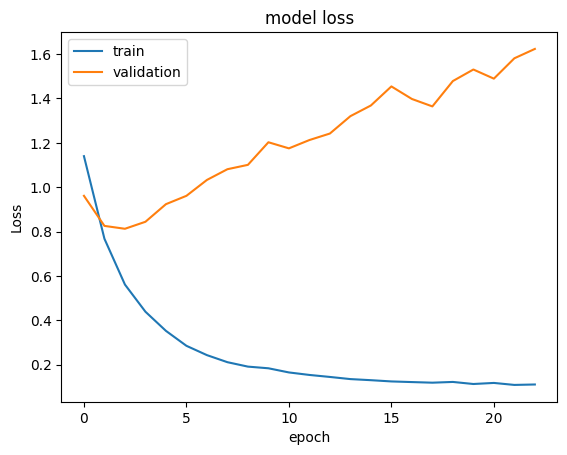

In [ ]:
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

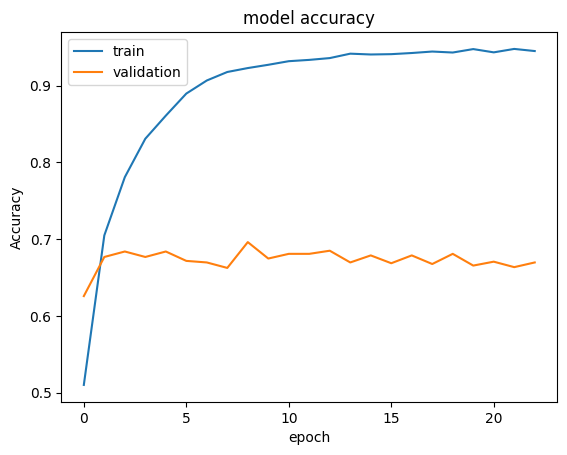

In [ ]:
plt.plot(histroy.history['accuracy'])
plt.plot(histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

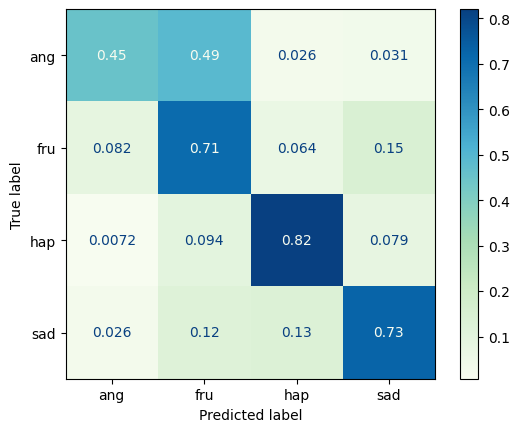

In [ ]:
y_pred = model.predict(x_val)
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [12]:
model.save('BertSingleSentence-val_ses01')

INFO:tensorflow:Assets written to: BertSingleSentence-val_ses01/assets


INFO:tensorflow:Assets written to: BertSingleSentence-val_ses01/assets


# Experiment 2

In [ ]:
data = get_train_validation_set(ses_for_validation=2)
x_train, y_train = data['x_train'], data['y_train']
x_val, y_val = data['x_val'], data['y_val']

train_x shape: (4686,)
train_y shape: (4686, 4)
val_x shape: (986,)
val_y shape: (986, 4)


In [ ]:
model = get_model()

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text_input[0][0]']             
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
histroy = model.fit(
    x_train,
    y_train,
    epochs=10000,
    validation_data=(x_val,y_val),
    batch_size=16,
    callbacks=callbacks
    )

Epoch 1/10000
293/293 [==============================] - 145s 462ms/step - loss: 1.3570 - accuracy: 0.3316 - val_loss: 1.3062 - val_accuracy: 0.3874
Epoch 2/10000
293/293 [==============================] - 135s 461ms/step - loss: 1.3023 - accuracy: 0.3967 - val_loss: 1.2439 - val_accuracy: 0.4686
Epoch 3/10000
293/293 [==============================] - 135s 461ms/step - loss: 1.2417 - accuracy: 0.4618 - val_loss: 1.1595 - val_accuracy: 0.5101
Epoch 4/10000
293/293 [==============================] - 135s 462ms/step - loss: 1.1643 - accuracy: 0.4962 - val_loss: 1.0893 - val_accuracy: 0.5598
Epoch 5/10000
293/293 [==============================] - 135s 462ms/step - loss: 1.0949 - accuracy: 0.5403 - val_loss: 1.0194 - val_accuracy: 0.5984
Epoch 6/10000
293/293 [==============================] - 135s 461ms/step - loss: 1.0313 - accuracy: 0.5777 - val_loss: 0.9705 - val_accuracy: 0.6045
Epoch 7/10000
293/293 [==============================] - 135s 462ms/step - loss: 0.9670 - accuracy: 0.6061

### Loss & Accuracy

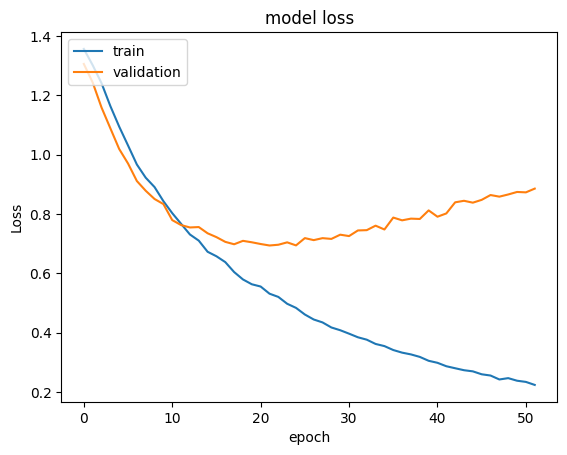

In [ ]:
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

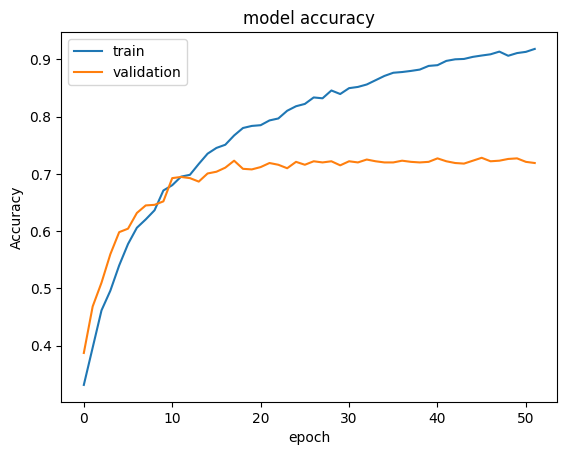

In [ ]:
plt.plot(histroy.history['accuracy'])
plt.plot(histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

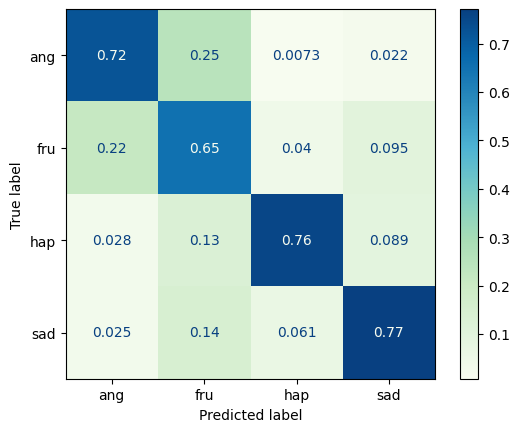

In [ ]:
y_pred = model.predict(x_val)
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [12]:
model.save('BertSingleSentence-val_ses02')

INFO:tensorflow:Assets written to: BertSingleSentence-val_ses02/assets


INFO:tensorflow:Assets written to: BertSingleSentence-val_ses02/assets


# Experiment 3

In [ ]:
data = get_train_validation_set(ses_for_validation=3)
x_train, y_train = data['x_train'], data['y_train']
x_val, y_val = data['x_val'], data['y_val']

train_x shape: (4459,)
train_y shape: (4459, 4)
val_x shape: (1213,)
val_y shape: (1213, 4)


In [ ]:
model = get_model()

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
histroy = model.fit(
    x_train,
    y_train,
    epochs=10000,
    validation_data=(x_val,y_val),
    batch_size=16,
    callbacks=callbacks
    )

Epoch 1/10000
279/279 [==============================] - 142s 472ms/step - loss: 1.3357 - accuracy: 0.3505 - val_loss: 1.3535 - val_accuracy: 0.3306
Epoch 2/10000
279/279 [==============================] - 131s 470ms/step - loss: 1.2800 - accuracy: 0.4135 - val_loss: 1.2948 - val_accuracy: 0.3735
Epoch 3/10000
279/279 [==============================] - 132s 472ms/step - loss: 1.1921 - accuracy: 0.4705 - val_loss: 1.2120 - val_accuracy: 0.4411
Epoch 4/10000
279/279 [==============================] - 132s 472ms/step - loss: 1.0929 - accuracy: 0.5369 - val_loss: 1.1386 - val_accuracy: 0.5021
Epoch 5/10000
279/279 [==============================] - 132s 472ms/step - loss: 1.0041 - accuracy: 0.5965 - val_loss: 1.0798 - val_accuracy: 0.5383
Epoch 6/10000
279/279 [==============================] - 132s 472ms/step - loss: 0.9333 - accuracy: 0.6223 - val_loss: 1.0335 - val_accuracy: 0.5631
Epoch 7/10000
279/279 [==============================] - 132s 472ms/step - loss: 0.8750 - accuracy: 0.6528

### Loss & Accuracy

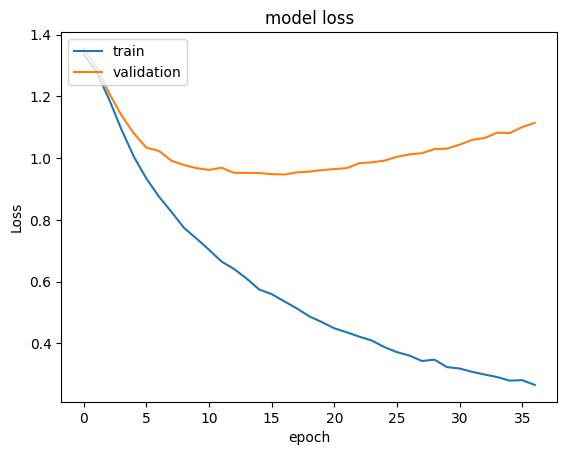

In [ ]:
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

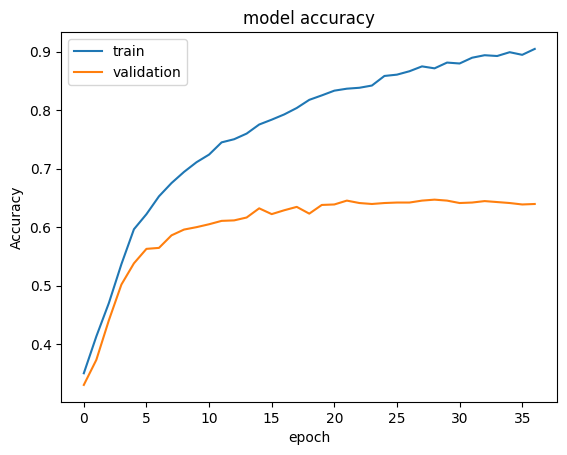

In [ ]:
plt.plot(histroy.history['accuracy'])
plt.plot(histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

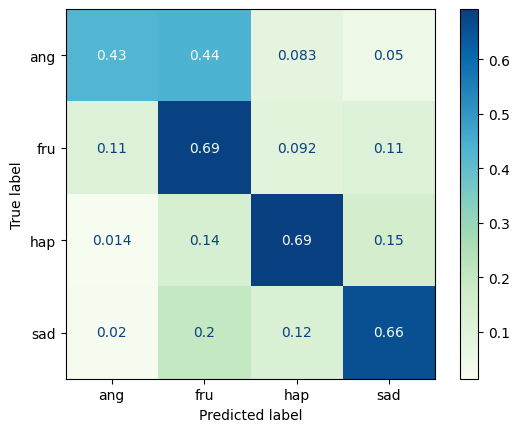

In [ ]:
y_pred = model.predict(x_val)
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [12]:
model.save('BertSingleSentence-val_ses03')

INFO:tensorflow:Assets written to: BertSingleSentence-val_ses03/assets


INFO:tensorflow:Assets written to: BertSingleSentence-val_ses03/assets


# Experiment 4

In [ ]:
data = get_train_validation_set(ses_for_validation=4)
x_train, y_train = data['x_train'], data['y_train']
x_val, y_val = data['x_val'], data['y_val']

train_x shape: (4418,)
train_y shape: (4418, 4)
val_x shape: (1254,)
val_y shape: (1254, 4)


In [ ]:
model = get_model()

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
histroy = model.fit(
    x_train,
    y_train,
    epochs=10000,
    validation_data=(x_val,y_val),
    batch_size=16,
    callbacks=callbacks
    )

Epoch 1/10000
277/277 [==============================] - 140s 469ms/step - loss: 1.3502 - accuracy: 0.3293 - val_loss: 1.3094 - val_accuracy: 0.4107
Epoch 2/10000
277/277 [==============================] - 129s 467ms/step - loss: 1.2730 - accuracy: 0.4187 - val_loss: 1.1976 - val_accuracy: 0.5048
Epoch 3/10000
277/277 [==============================] - 130s 469ms/step - loss: 1.1593 - accuracy: 0.5034 - val_loss: 1.1079 - val_accuracy: 0.5295
Epoch 4/10000
277/277 [==============================] - 130s 469ms/step - loss: 1.0735 - accuracy: 0.5564 - val_loss: 1.0463 - val_accuracy: 0.5494
Epoch 5/10000
277/277 [==============================] - 130s 471ms/step - loss: 1.0082 - accuracy: 0.5901 - val_loss: 1.0222 - val_accuracy: 0.5606
Epoch 6/10000
277/277 [==============================] - 131s 472ms/step - loss: 0.9477 - accuracy: 0.6247 - val_loss: 0.9560 - val_accuracy: 0.5957
Epoch 7/10000
277/277 [==============================] - 131s 472ms/step - loss: 0.8919 - accuracy: 0.6424

### Loss & Accuracy

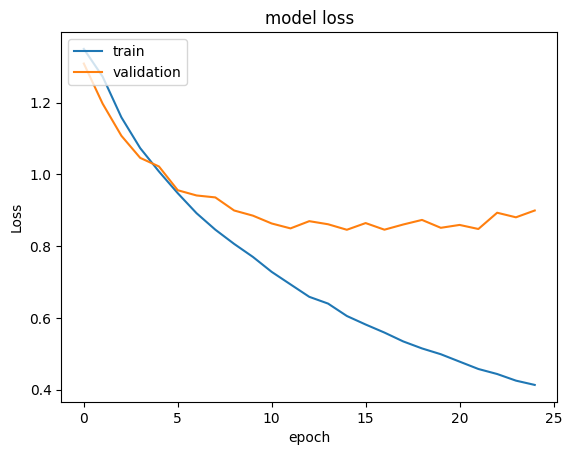

In [ ]:
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

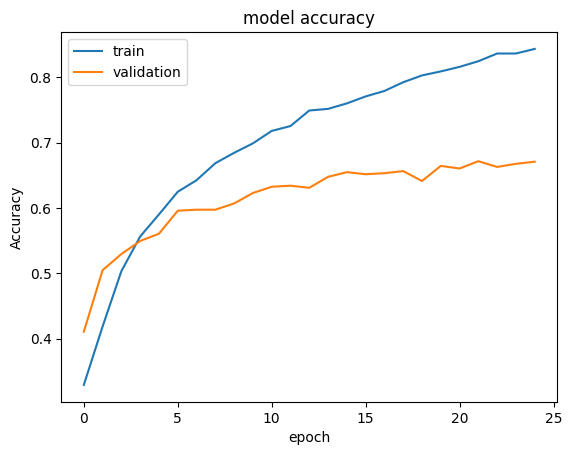

In [ ]:
plt.plot(histroy.history['accuracy'])
plt.plot(histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

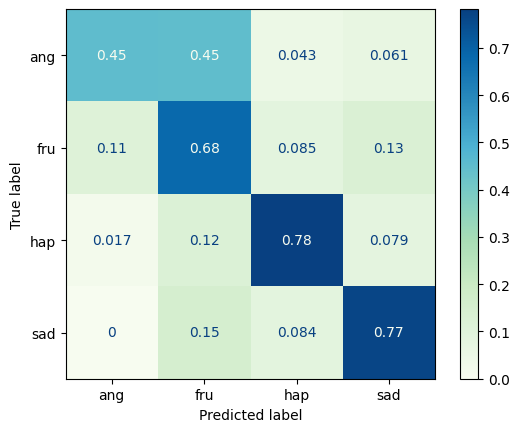

In [ ]:
y_pred = model.predict(x_val)
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [12]:
model.save('BertSingleSentence-val_ses04')

INFO:tensorflow:Assets written to: BertSingleSentence-val_ses04/assets


INFO:tensorflow:Assets written to: BertSingleSentence-val_ses04/assets


# Experiment 5

In [ ]:
data = get_train_validation_set(ses_for_validation=5)
x_train, y_train = data['x_train'], data['y_train']
x_val, y_val = data['x_val'], data['y_val']

train_x shape: (4434,)
train_y shape: (4434, 4)
val_x shape: (1238,)
val_y shape: (1238, 4)


In [ ]:
model = get_model()

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_func,
    metrics=['accuracy'])

In [ ]:
histroy = model.fit(
    x_train,
    y_train,
    epochs=10000,
    validation_data=(x_val,y_val),
    batch_size=16,
    callbacks=callbacks
    )

Epoch 1/10000
278/278 [==============================] - 142s 472ms/step - loss: 1.3979 - accuracy: 0.2819 - val_loss: 1.2981 - val_accuracy: 0.4305
Epoch 2/10000
278/278 [==============================] - 131s 470ms/step - loss: 1.2952 - accuracy: 0.4109 - val_loss: 1.2280 - val_accuracy: 0.4838
Epoch 3/10000
278/278 [==============================] - 131s 470ms/step - loss: 1.2225 - accuracy: 0.4657 - val_loss: 1.1670 - val_accuracy: 0.5081
Epoch 4/10000
278/278 [==============================] - 131s 470ms/step - loss: 1.1463 - accuracy: 0.5151 - val_loss: 1.0901 - val_accuracy: 0.5372
Epoch 5/10000
278/278 [==============================] - 131s 470ms/step - loss: 1.0861 - accuracy: 0.5379 - val_loss: 1.0431 - val_accuracy: 0.5565
Epoch 6/10000
278/278 [==============================] - 131s 470ms/step - loss: 1.0304 - accuracy: 0.5690 - val_loss: 1.0140 - val_accuracy: 0.5897
Epoch 7/10000
278/278 [==============================] - 131s 470ms/step - loss: 0.9700 - accuracy: 0.6105

### Loss & Accuracy

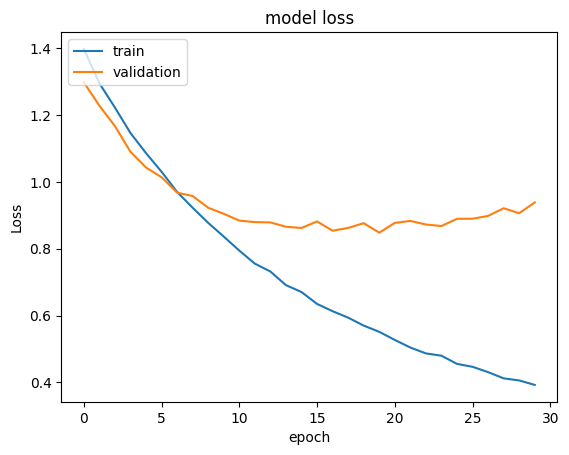

In [ ]:
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

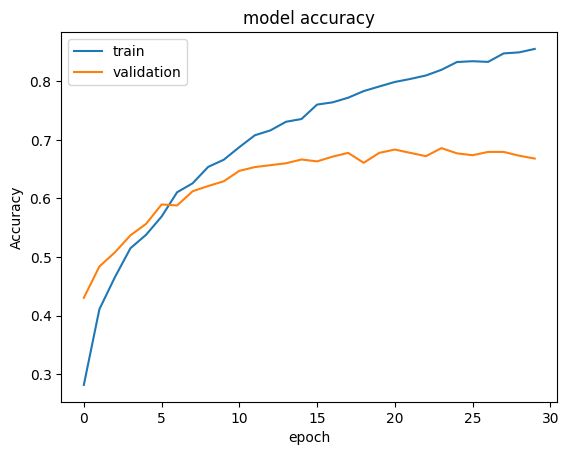

In [ ]:
plt.plot(histroy.history['accuracy'])
plt.plot(histroy.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

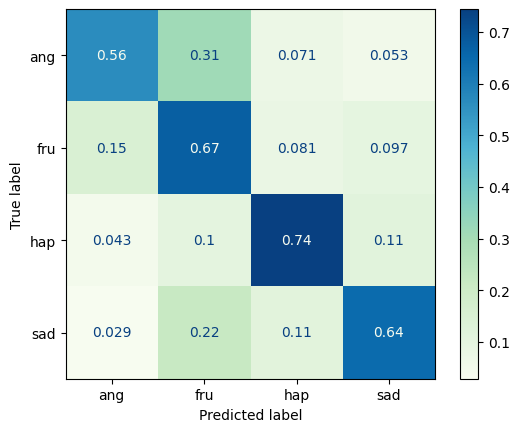

In [ ]:
y_pred = model.predict(x_val)
ConfusionMatrixDisplay.from_predictions(
  list(map(lambda prediction:classes[prediction],y_val.argmax(axis=1))),
  list(map(lambda prediction:classes[prediction],y_pred.argmax(axis=1))),
  normalize='true',cmap='GnBu')
plt.show()

In [12]:
model.save('BertSingleSentence-val_ses05')

INFO:tensorflow:Assets written to: BertSingleSentence-val_ses05/assets


INFO:tensorflow:Assets written to: BertSingleSentence-val_ses05/assets
